# Supervised Classification - Naive Bayes Classifier

### Objective: Predict if a mail is spam or not 

In this exercise various classification algorithms are implented to predict if a mail is spam or not. 

**Data Description:** 

* Number of Observations: 4601 (1813 Spam = 39.4%)
* Number of Attributes: 58 (57 continuous, 1 nominal class label)

** Attributes **

* 48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string. 

* 6 continuous real [0,100] attributes of type char_freq_CHAR] = percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail 

* 1 continuous real [1,...] attribute of type capital_run_length_average  = average length of uninterrupted sequences of capital letters 

* 1 continuous integer [1,...] attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters 

* 1 continuous integer [1,...] attribute of type capital_run_length_total  = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail 

* 1 nominal {0,1} class attribute of type spam = denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 

Refer: https://archive.ics.uci.edu/ml/datasets/spambase for detailed data description

In this exercise we will build and implement 3 basic classification techniques:
   1. Naive Bayes Classifier
   2. K-Nearest Neighbors Classifier (K-NN)
   3. Logistic Regression

**1. Naive Bayes Classifier**

Under the iid assumption, the optimum classifier is:

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\ |\ X = x\right)
\end{equation}

Applying Bayes Rule we split the posterior into class prior and class conditional distribution of X

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\right) \times P\left(X = x\ |\ Y = y\right)
\end{equation}

Naive Bayes classifier treats the dimensions of X as conditionally independent given y, hence we get:

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\right) \times \prod^{d}_{j=1} p_j \left(x[j]|Y=y \right)
\end{equation}

### Import Data and relevant Libraries

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')

import math 
import numpy as np
import numpy.linalg as nplg
import matplotlib.pyplot as plt
from scipy.special import expit
import itertools

%matplotlib inline

#Import Data as Numpy Matrices
X_train = np.genfromtxt ('X_train.csv', delimiter=",")
Y_train = np.genfromtxt ('y_train.csv',delimiter=",")
X_test = np.genfromtxt ('X_test.csv', delimiter=",")
Y_test = np.genfromtxt ('y_test.csv',delimiter=",")

In [25]:
#Function for computing Bernouli MLE
def bern_MLE(X,Y,a):
    sum=0.0
    count=0
    for i in xrange(len(X)):
        if Y[i]==a:
            sum+=X[i]
            count+=1
        else:
            continue
    return (sum/count)

# Function for computing Pareto MLE
def pareto_MLE(X,Y,a):
    sum=0.0
    count=0
    for i in xrange(len(X)):
        if Y[i]==a: 
            sum+=math.log(X[i])
            count+=1
        else:
            continue
    return count/sum

# Function for calculating Accuracy
def Accuracy(Y_test,Y_pred,label=0):
    mat= np.zeros((2,2))
    for i in xrange(len(y_pred)):
        if Y_pred[i]==label and Y_test[i]==label:
            mat[0][0]+=1
        elif Y_pred[i]==label and Y_test[i]==1:
            mat[0][1]+=1
        elif Y_pred[i]==1 and Y_test[i]==label:
            mat[1][0]+=1
        else:
            mat[1][1]+=1
    return mat,round(100*(np.trace(mat))*1.0/len(Y_test),3)

def confusion_matrix(cm, classes,
                          title,
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Implementing Naive Bayes on the Spam base data

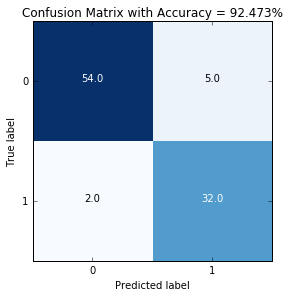

In [26]:
# Obtain feature MLE vectors by applying respective funtions for each distribution given class
MLE_Ytrain_bern = np.mean(Y_train)

MLE_Xtrain_bern0 = np.apply_along_axis(bern_MLE,0,X_train[:,0:54],Y_train,0)
MLE_Xtrain_bern1 = np.apply_along_axis(bern_MLE,0,X_train[:,0:54],Y_train,1)
    
MLE_Xtrain_par0 = np.apply_along_axis(pareto_MLE,0,X_train[:,54:],Y_train,0)
MLE_Xtrain_par1 = np.apply_along_axis(pareto_MLE,0,X_train[:,54:],Y_train,1)

# Concatenate Bernouli and Pareto MLEs into one vector for each class
MLE_Xtrain0=np.concatenate((MLE_Xtrain_bern0,MLE_Xtrain_par0))
MLE_Xtrain1=np.concatenate((MLE_Xtrain_bern1,MLE_Xtrain_par1))

    
# Calculate values for posterior given y_test=0

post_y0=[]
for i in xrange(len(X_test)):
    prod=(1-MLE_Ytrain_bern)
    for j in xrange(len(X_test[i,:])):
        if j<54:
            prod*=((MLE_Xtrain0[j])**X_test[i,j])*((1-MLE_Xtrain0[j])**(1-X_test[i,j]))
        else:
            prod*=(MLE_Xtrain0[j])*((X_test[i,j])**(-(1+((MLE_Xtrain0[j])))))
    post_y0.append(prod)

# Calculate values for posterior given y_test=1  
post_y1=[]
for i in xrange(len(X_test)):
    prod=MLE_Ytrain_bern
    for j in xrange(len(X_test[i,:])):
        if j<54:
            prod*=((MLE_Xtrain1[j])**X_test[i,j])*((1-MLE_Xtrain1[j])**(1-X_test[i,j]))
        else:
            prod*=(MLE_Xtrain1[j])*((X_test[i,j])**(-(1+((MLE_Xtrain1[j])))))
    post_y1.append(prod)

y_pred=[]

for i in xrange(len(post_y0)):
    if post_y0[i]>post_y1[i]:
        y_pred.append(0)
    else:
        y_pred.append(1)

confusion_matrix(Accuracy(Y_test,y_pred)[0],classes=['0','1'],title='Confusion Matrix with Accuracy = ' + str(Accuracy(Y_test,y_pred)[1])+'%')

### (b) In one figure, show a stem plot (stem() in Matlab) of the 54 Bernoulli parameters for each class. Use the file “spambase.names” to make an observation about dimensions 16 and 52.

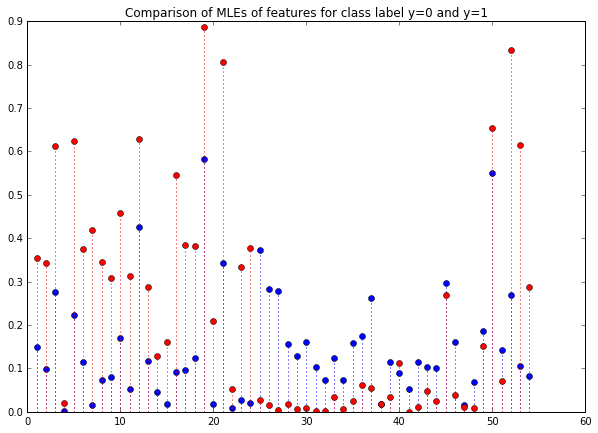

In [27]:
#Stem Plot
import pylab as plb

x = [i for i in xrange(1,55)]
# f = plt.subplots(1, 2, sharey=True,figsize=(15,5))


plt.figure(figsize=(10,7))
markerline1, stemlines1, baseline1 = plt.stem(x,MLE_Xtrain_bern0, markerfmt='o', label='y=0')
plt.setp(markerline1,'markerfacecolor','b')
plt.setp(stemlines1, 'color','b')
plt.setp(stemlines1, 'linestyle', 'dotted')

markerline2, stemlines2, baseline2 = plt.stem(x,MLE_Xtrain_bern1, markerfmt='o', label='y=1',color='r')
plt.setp(markerline2,'markerfacecolor','r')
plt.setp(stemlines2, 'color', 'r')
plt.setp(stemlines2, 'linestyle', 'dotted')
# plt.set_title("Comparison of MLEs of features for class label y=1")
plt.title("Comparison of MLEs of features for class label y=0 and y=1")

plt.show()

The 16th dimension is the frequency of the word 'free' and 52nd dimension is the frequency of exclamation mark '!'. The following are the inferences that can be made:

* For class label y=1, both dimensions (16th and 52nd) have much higher MLE values when compared class y=0. This is expected as most spam mails (which are promotions or advertisements) are likely to contain 'free' and '!'. **Given that the mail is spam (y=1) the probability of occurence of 'free' and '!' is high when compared to non=spam**

* The ratio of the MLE's of the two dimensions is closer to 1 (1.537) for spam mails when compared to non-spam (2.95). This shows likely co-occurance of these two expressions in spam mails. Creation of an interation variable between the two dimensions could be a good predictor of spam mails.